# Stock Trend Prediction using XGBoost

# Environment Setup

In [2]:
# Import the required libraries
import pandas as pd
import pandas_datareader as web
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from scipy.stats.stats import pearsonr
sns.set()
plt.style.use('fivethirtyeight')
%matplotlib inline

# import machine learning methods
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import  GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from xgboost import XGBClassifier

# Import Data

In [4]:
# Get the stock quote, SP500
df = web.DataReader("^GSPC", data_source='yahoo', start ='2016-01-01', end ='2020-12-02')
# show data
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-25,3635.500000,3617.760010,3635.500000,3629.649902,4902560000,3629.649902
2020-11-27,3644.310059,3629.330078,3638.550049,3638.350098,2778450000,3638.350098
2020-11-30,3634.179932,3594.389893,3634.179932,3621.629883,6291400000,3621.629883
2020-12-01,3678.449951,3645.870117,3645.870117,3662.449951,5403660000,3662.449951
2020-12-02,3670.959961,3644.840088,3653.780029,3669.010010,5029620000,3669.010010


In [5]:
# get shape of data set
df.shape

(1239, 6)

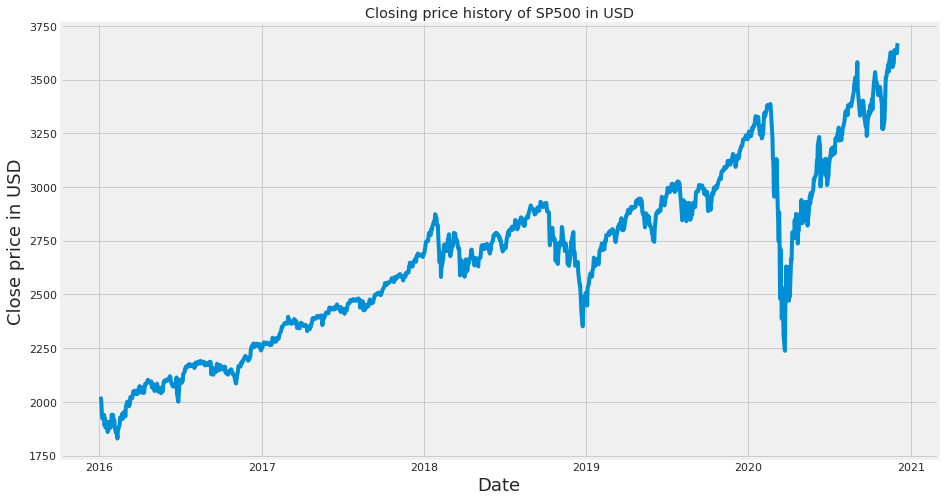

In [6]:
# visualize the closing price history
plt.figure(figsize=(14,8))
plt.title('Closing price history of SP500 in USD')
plt.plot(df.Close)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price in USD', fontsize=18)
plt.show()

# Smoothing historical stock data

In [7]:
# create data frane only with price information
df_prices = df.drop('Volume', axis=1)

# function to smooth price data
def df_smoothing(data):
    """
    function to perform simple exponential smoothing.
    INPUT: a pandas data frame.
    OUTPUT: exponential smoothed pandas data frame.
    """
      
    # Converting the index as date
    index = pd.DatetimeIndex(data.index).to_period('D')
    df = pd.DataFrame(index=index)
    for column in data.columns:
        series = pd.Series(data[column].values, index)
        model= SimpleExpSmoothing(series)
        df[column] = model.fit().fittedvalues.values
    
    return df

df_smoothed = df_smoothing(df_prices)
# add column volume to smoothed data
df_smoothed['Volume'] = df.Volume.values
# show smoothed data frame
df_smoothed.tail()

,High,Low,Open,Close,Adj Close,Volume
Date,,,,,,
2020-11-25,3642.310059,3594.520020,3594.520020,3625.157952,3625.157952,4902560000
2020-11-27,3635.500000,3617.760010,3635.500000,3628.889351,3628.889351,2778450000
2020-11-30,3644.310059,3629.330078,3638.550049,3636.748258,3636.748258,6291400000
2020-12-01,3634.179932,3594.389893,3634.179932,3624.189640,3624.189640,5403660000
2020-12-02,3678.449951,3645.870117,3645.870117,3655.971934,3655.971934,5029620000


# Technical Indicators

In [8]:

# Relative Strength Index
def RSI_indicator(price, window_length=14):
    """
    function to compute Relative Strength Index.
    INPUT: numpy array of prices, window length
    OUTPUT: numpy array containing Relative Strength Index values
    """
    
    difference = np.diff(price)
    # building arrays with same lengh
    up, down = difference.copy(), difference.copy()
    up[up<0]=0
    down[down>0]=0
    # price movements series
    price_up = pd.Series(up)
    price_down = pd.Series(down)
    # Average Gain Over past n days
    ag = price_up.rolling(window_length).mean()
    # Average Loss Over past n days
    al=price_down.rolling(window_length).mean().abs()
    
    rs = ag/al
    rsi = 100.0 - (100.0/ (1 + rs))
    return rsi.values

# Stochastic Oscillator 
def SO_indicator(data, window_length=14):
    """
    function to compute Stochastic Oscillator.
    INPUT: a pandas data frame containing Low, High and Close attributes
           and a window_length
    OUTPUT: numpy array containing Stochastic Oscillator values
    """
       
    #Create the "L14" values
    l14 = data['Low'].rolling(window_length).min()
    #Create the "H14" values
    h14 = data['High'].rolling(window_length).max()
    # Closing Price
    c = data["Close"]
    #Create the "%K" values
    k = 100*((c - l14) / (h14 - l14) )
    return k.values


# Williams %R
def WR_indicator(data, window_length=14):
    """
    function to compute Williams %R.
    INPUT:  a pandas data frame containing Low, High and Close attributes
           and a window_length
    OUTPUT: numpy array containing Williams %R values
    """
    
    #Create the "L14" values
    l14 = data['Low'].rolling(window_length).min()
    #Create the "H14" values
    h14 = data['High'].rolling(window_length).max()
    # Closing Price
    c = data["Close"]
    #Create the Williams %R values
    r = ((h14 - c)/(h14 - l14))*(-100)
    return r.values


# Moving Average Convergence Divergence and signalline
def MACD_indicator(price):
    """
    function to compute Moving Average Convergence Divergence.
    INPUT: a pandas series of prices.
    OUTPUT: a pandas data frame containing Moving Average Convergence Divergence and signalline
    """
    
    # 12 day Exponential Moving Average
    ema12 = price.ewm(span=12, adjust=False).mean()
    #26 day Exponential Moving Average
    ema26 = price.ewm(span=26, adjust=False).mean()
    # Moving Average Convergence Divergence
    macd = ema12 - ema26
    # SignalLine
    sl = macd.ewm(span=9, adjust=False).mean()
    # data frame 
    df = pd.DataFrame(columns = ['MACD', 'signal'], index=price.index)
    df.MACD = macd.values
    df.signal = sl.values
    return df



# Price Rate of Change
def PRC_indicator(price, window_length=14):
    """
    function to compute Price Rate of Change.
    INPUT: a pandas series of prices and window_length.
    OUTPUT: numpy array containing  Price Rate of Change values.
    """
    num = price.diff(window_length)
    den = price.shift(window_length)
    pcr = num/den
    return pcr.values 


# Commodity Channel Index
def CCI_indicator(data, window_length=14):
    """
    function to Commodity Channel Index.
    INPUT: a pandas data frame containing Low, High and Close attributes
           and a window_length
    OUTPUT: numpy array containing  Commodity Channel Index values.
    """
       
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    cci = pd.Series((typical_price - typical_price.rolling(window_length).mean()) / (0.015 * typical_price.rolling(window_length).std())) 
    return cci.values

# Force Index
def FI_indicator(data, window_length=14):
    """
    function to compute Force Index.
    INPUT: a pandas data frame containing Close and Volume attributes
           and a window_length.
    OUTPUT: numpy array containing Force Index values.
    """
      
    fi = pd.Series(data['Close'].diff(window_length) * data['Volume']) 
    return fi.values


# Compute Technical Indicators

In [9]:
# we use smoothed data to construct technical indicators
# window of all indicators is set to 14

K = SO_indicator(df_smoothed)
print('Length of SO indicator is:', '{}'.format(len(K)))

R = WR_indicator(df_smoothed)
print('Length of WR indicator is:', '{}'.format(len(R)))

MACD = MACD_indicator(df_smoothed['Close'])['MACD'].values
print('Length of MACD indicator is:', '{}'.format(len(MACD)))

MACD_signal = MACD_indicator(df_smoothed['Close'])['signal'].values
print('Length of MACD Signal indicator is:', '{}'.format(len(MACD_signal)))

PROC = PRC_indicator(df_smoothed['Close'])
print('Length of PROC indicator is:', '{}'.format(len(PROC)))

CCI = CCI_indicator(df_smoothed)
print('Length of CCI indicator is:', '{}'.format(len(CCI)))

FI = FI_indicator(df_smoothed)
print('Length of FI indicator is:', '{}'.format(len(FI)))

# to compute RSI indicator we need to drop the observation in Close attribute
RSI = RSI_indicator(df_smoothed['Close'].values[0:])
print('Length of RSI indicator is:', '{}'.format(len(RSI)))


Length of SO indicator is: 1239
Length of WR indicator is: 1239
Length of MACD indicator is: 1239
Length of MACD Signal indicator is: 1239
Length of PROC indicator is: 1239
Length of CCI indicator is: 1239
Length of FI indicator is: 1239
Length of RSI indicator is: 1238


# Train Labels and Features

In [10]:
# set number of dates to be predicted
n_days_predic = 20
# create labels and delete first observation
labels = np.sign(df_smoothed['Close'].diff(n_days_predic))[1:]

# create data frame with features
# keep from df_smoothed data frame Close and Volume 
# fand delete  irst row to match with tecnical indicators features
df_features = df_smoothed.filter(['Close', 'Volume']).drop(df_smoothed.index[0])
# add technical indicators
df_features['RSI'] = RSI
df_features['%K'] = K[1:]
df_features['%R'] = R[1:]
df_features['MACD'] = MACD[1:]
df_features['MACD_signal'] = MACD_signal[1:]
df_features['PROC'] = PROC[1:]
df_features['CCI'] = CCI[1:]
df_features['FI'] = FI[1:]

# create data frame with features and labels
DF = df_features.copy()
DF.insert(0, "labels", labels)

# delete missing values from data set 
DF.dropna(how='any', inplace=True)

# show data 
DF.tail()



,labels,Close,Volume,RSI,%K,%R,MACD,MACD_signal,PROC,CCI,FI
Date,,,,,,,,,,,
2020-11-25,1.0,3625.157952,4902560000,76.283578,87.112867,-12.887133,50.534987,44.059433,0.057203,97.506282,9.616313e+11
2020-11-27,1.0,3628.889351,2778450000,71.381032,89.421188,-10.578812,52.165405,45.680628,0.037816,98.668431,3.673903e+11
2020-11-30,1.0,3636.748258,6291400000,71.123617,93.107304,-6.892696,53.475242,47.239550,0.036915,109.627357,8.145601e+11
2020-12-01,1.0,3624.189640,5403660000,64.306513,84.803326,-15.196674,52.890235,48.369687,0.022863,59.967242,4.377399e+11
2020-12-02,1.0,3655.971934,5029620000,67.708969,85.939804,-14.060196,54.364499,49.568650,0.031265,124.552208,5.574807e+11


# Looking for Correlations

<AxesSubplot:>

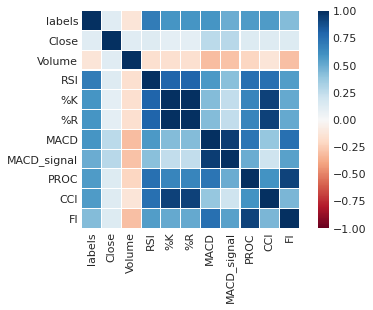

In [11]:
# heat map to evaluate correlations

sns.heatmap(DF.corr(), cmap='RdBu',vmin= -1, vmax= 1, linewidth = 0.1,square= True)

# Prepare  the Data for Machine Learning

In [12]:
# feature scaling
pipeline = Pipeline([('std_scaler', StandardScaler())])
# scale features
features = DF.drop('labels', axis=1)
features_scaled = pipeline.fit_transform(features)

# create data frame with scaled features
df_features_scaled = pd.DataFrame(features_scaled)
df_features_scaled.columns = DF.columns[1:]

# create labels and scaled features data set
df_scaled = df_features_scaled.copy()
target = np.array(DF['labels'])
df_scaled.insert(0, "labels", target)



# Model Selection

In [14]:
# forward selection binning algorithm

def ForwardSelection(X, Y, model):
    """
    fordward selection with accuracy as a performance measure.
    INPUT: X: a pandas data frame of features
           Y: a  pandas series of labels 
           model: the machine learning algorithm
    OUTPUT: a pandas data frame summarising best features
           
    """
    # Create list to store accuracies and chosen features
    accuracy_by_feature_number = []
    chosen_features = []
    
    # Initialise chosen features list and run tracker
    available_features = list(X.columns)
    run = 0
    number_of_features = len(available_features)
    
    
    # Loop through feature list to select next feature
    while len(available_features)> 0:
        
        # Track and pront progress
        run += 1
        print ('Feature run {} of {}'.format(run, number_of_features))
        
        # Convert DataFrames to NumPy arrays
        Y_np = Y.values
        
        # Reset best feature and accuracy
        best_result = 0
        best_feature = ''
        
        
        # Loop through available features
        for feature in available_features:
            
            

            # Create copy of already chosen features to avoid original being changed
            features_to_use = chosen_features.copy()
            # Create a list of features from features already chosen + 1 new feature
            features_to_use.append(feature)
            
            # Get data for features, and convert to NumPy array
            X_np = X[features_to_use].values
            
            # Set up lists to hold results for each selected features
            test_accuracy_results = []
            
            # Set up k-fold training/test splits
            number_of_splits = 5
            skf = StratifiedKFold(n_splits = number_of_splits)
            skf.get_n_splits(X_np, Y)
        
            # Loop through the k-fold splits
            for train_index, test_index in skf.split(X_np, Y_np):
            
                # Get X and Y train/test
                X_train, X_test = X_np[train_index], X_np[test_index]
                Y_train, Y_test = Y_np[train_index], Y_np[test_index]
    
    
                # Set up and fit model
                cl_model = model
                cl_model.fit(X_train,Y_train)
                
    
                # Predict test set labels
                y_pred_test = model.predict(X_test)
            
                # Get recall
                probabilities = model.predict_proba(X_test)
                probabilities = probabilities[:, 1] 
                accuracy = accuracy_score(Y_test, y_pred_test)
                test_accuracy_results.append(accuracy)
                              
                
            # Get average result from all k-fold splits
            feature_accuracy = np.mean(test_accuracy_results)
            
            
            # Update chosen feature and result if this feature is a new best
            if feature_accuracy > best_result:
                best_result = feature_accuracy
                best_feature = feature
            
                
            
        # k-fold splits are complete    
        # Add mean recall  to record of accuracy by feature number
        accuracy_by_feature_number.append(best_result)
        chosen_features.append(best_feature)
        available_features.remove(best_feature)
        
        
    
    # Put results in DataFrame
    results = pd.DataFrame()
    results['feature to add'] = chosen_features
    results['accuracy'] = accuracy_by_feature_number
        
    return results

In [15]:
model = XGBClassifier()
result = ForwardSelection(df_features_scaled, DF.labels, model)
result

Feature run 1 of 10
Feature run 2 of 10
Feature run 3 of 10
Feature run 4 of 10
Feature run 5 of 10
Feature run 6 of 10
Feature run 7 of 10
Feature run 8 of 10
Feature run 9 of 10
Feature run 10 of 10


,feature to add,accuracy
0,PROC,0.870391
1,MACD,0.891719
2,FI,0.890083
3,RSI,0.890076
4,%K,0.890090
5,MACD_signal,0.894185
6,%R,0.894185
7,CCI,0.891729
8,Close,0.891743
9,Volume,0.889267


In [16]:
# select best features
model_features = result['feature to add'].values[:7]
model_features

array(['PROC', 'MACD', 'FI', 'RSI', '%K', 'MACD_signal', '%R'],
      dtype=object)

# Training and Evaluating on the Training Set

In [17]:
# the way to train a test time series is via sliding windows

def sliding(data, window_size, obs, n_sliding):
    """
    function to construct sliding windows for a data frame.
    INPUT: data: a padas data frame, including labels.
           window_size: size training window.
           obs: size testing window.
           n_sliding: number of slindings.
    OUTPUT: a list which elements are pairs of train and test data sets
    """
    samples = []
    if int((window_size + obs*n_sliding) + obs) > data.shape[0]:
        print('Error: Check the shape of your data')
    else:
        for n in range(0, n_sliding):
            train = data.loc[:data.index[(window_size + obs*n) -1]].loc[data.index[obs*n]:]
            test = data.loc[data.index[window_size + obs*n]:data.index[int((window_size + obs*n) + (obs-1))]]
            samples.append([train,test])
    return samples



In [18]:
# look for sectors in the data where a accuracy is maximal
def sliding_xgb(data, name_target, cols, window_size, obs, n_sliding):
    
    """
    function to get the best segments of the data using xgboost based on accuracy score
    INPUT: data: a pandas data frame.
           name_target: name of the target or label.
           cols: attributes of the model.
           window_size: size training window.
           obs: size testing window.
           n_sliding: number of slindings. 
           
    OUTPUT: pandas data frame containing accuracy in and out of sample,
            sectors of data frame where accuracy is maximal.
           
    """
    
    # preparing data for sliding windows
    data_1 = data[cols]
    data_1.insert(0, 'labels', data[name_target].values)
       
    # sliding function has as an input the whole data set, including labels
    train_test = sliding(data_1, window_size, obs, n_sliding)

    # performance
    perf_accuracy_in = []
    perf_accuracy_out = []

    for i in range(0,n_sliding):
        
        # train features and labels
        train_f = train_test[i][0].drop('labels', axis=1).values
        train_l = train_test[i][0].labels.values
        
        # test
        test_f = train_test[i][1].drop('labels', axis=1).values
        test_l = train_test[i][1].labels.values
        
        # initialize XGBoost classifier
        xgb = XGBClassifier().fit(train_f,train_l)
        
        # results in trainig for recall
        probs_in = xgb.predict_proba(train_f)[:, 1]
        predictions_in = xgb.predict(train_f)
        accuracy_in = accuracy_score(train_l, predictions_in)*100
        perf_accuracy_in.append(accuracy_in)
        
        # results in testing
        probs_out = xgb.predict_proba(test_f)[:, 1]
        predictions_out = xgb.predict(test_f)
        accuracy_out = accuracy_score(test_l, predictions_out)*100
        perf_accuracy_out.append(accuracy_out)
        

    #outline of results    
    df_results = pd.DataFrame(columns=['accuracy_in', 'accuracy_out'], index= np.arange(0,n_sliding))
    df_results['accuracy_in'] = perf_accuracy_in
    df_results['accuracy_out'] = perf_accuracy_out
    
    # get best train/test sector according to best performance outsample
    # take list of accuracy_out
    a_out = df_results['accuracy_out'].values
    # find the index where max accuracy is
    index_max = np.where(a_out == a_out.max())[0]
    # best sectors
    accuracy_best_sectors =[]
    for i in index_max:
        accuracy_best_sectors.append(train_test[i])
        
        
    return df_results, accuracy_best_sectors
           

In [22]:
# set parameters for sliding windows
window_size = 200
obs = 20
n_sliding = 49

# find best sectors
sliding_results, best_sectors= sliding_xgb(df_scaled, 'labels', model_features, window_size, obs, n_sliding)

In [23]:
# show results
sliding_results

,accuracy_in,accuracy_out
0,100.0,100.0
1,100.0,100.0
2,100.0,100.0
3,100.0,100.0
4,100.0,30.0
5,100.0,80.0
6,100.0,85.0
7,100.0,85.0
8,100.0,95.0
9,100.0,85.0


# Grid Search

In [24]:
# take the most recent sector with highest accuracy
best_sector = best_sectors[-1]
# set train  and test data frames
train_in = best_sector[0]
test_in = best_sector[1]

In [25]:
def xgb_gridsearch(train, test, score, scoring,  grid):
    
    """
    Function to perform Grid Serach using XGBoost. 

    INPUT:
    train : data frame containing labesl.
    test : data frame containing labesl.
    score : score metric.
    scoring : scoring value.
    grid : dictionary of hyperparameters.
    OUTPUT:
    df_results : data frame with results in testing.
    and best grid.

    """
    # train features and labels
    train_f = train.drop('labels', axis=1).values
    train_l = train.labels.values
        
    # test
    test_f = test.drop('labels', axis=1).values
    test_l = test.labels.values
    
    
    # Create a based model
    GS_xgb = XGBClassifier()
    #Instantiate the grid search model
    grid_search = GridSearchCV(estimator = GS_xgb, param_grid = grid, scoring=scoring, 
                           cv = 5, n_jobs = -1, verbose = 2)

    # Fit the grid search to the data
    grid_result = grid_search.fit(train_f, train_l)
     
    # preformance
    predictions = grid_result.predict(test_f)      
    scorer = score(test_l, predictions)*100  
    # outline results
    df_results = pd.DataFrame(columns=['accuracy_out'], index =[0])    
    df_results['accuracy_out'] = scorer
    
    return df_results, grid_result.best_params_

In [26]:
# set grid of hyperparameters
param_grid = {
     'max_depth': range(4,10),
     'min_child_weight': range(1,7),
     'learning_rate' : np.linspace(0.01,0.2,5)
    
     }
grid_search_results, best_grid = xgb_gridsearch(train_in, test_in, accuracy_score, 'accuracy', param_grid)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 879 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   10.8s finished


In [27]:
# show results
grid_search_results

,accuracy_out
0,100.0


In [28]:
# show best hyperparameters
best_grid

{'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 6}

# Prepare the Test Set

In [30]:
# download data to test the model
test_data = web.DataReader("^GSPC", data_source='yahoo',  start ='2020-12-02', end = '2021-01-31')

# compute technical indicators 
K = SO_indicator(test_data)

R = WR_indicator(test_data)

MACD = MACD_indicator(test_data['Close'])['MACD'].values

MACD_signal = MACD_indicator(test_data['Close'])['signal'].values

PROC = PRC_indicator(test_data['Close'])

CCI = CCI_indicator(test_data)

FI = FI_indicator(test_data)

RSI = RSI_indicator(test_data['Close'].values[0:])

# set number of dates to be predicted
n_days_predic = 20
# create labels and delete first observation
labels = np.sign(test_data['Close'].diff(n_days_predic))[1:]

# create data frame with features
# keep from test_data data frame Close and Volume 
# and delete  first row to match with tecnical indicators features
df_test_features = test_data.filter(['Close', 'Volume']).drop(test_data.index[0])
# add technical indicators
df_test_features['RSI'] = RSI
df_test_features['%K'] = K[1:]
df_test_features['%R'] = R[1:]
df_test_features['MACD'] = MACD[1:]
df_test_features['MACD_signal'] = MACD_signal[1:]
df_test_features['PROC'] = PROC[1:]
df_test_features['CCI'] = CCI[1:]
df_test_features['FI'] = FI[1:]

# create data frame with features and labels
DF_test = df_test_features.copy()
DF_test.insert(0, "labels", labels)

# delete missing values from data set 
DF_test.dropna(how='any', inplace=True)

# scale features
test_features = DF_test.drop('labels', axis=1)
test_features_scaled = pipeline.transform(test_features)

# create data frame with scaled features
test_features_scaled = pd.DataFrame(test_features_scaled)
test_features_scaled.columns = DF_test.columns[1:]

# create labels and scaled features data set
df_test_scaled = test_features_scaled.copy()
target = np.array(DF_test['labels'])
df_test_scaled.insert(0, "labels", target)

# prepare data for xgboost classfier
#  test labels
y_test = df_test_scaled.labels
# test features
X_test = df_test_scaled[model_features]
# train labels
y_train = train_in.labels
# train features
X_train = train_in.drop('labels', axis=1)


In [33]:
# function to evalute model on the test set using xgboost
def best_xgb(X_train, X_test, y_train, y_test, score, grid):
    
    """
    function to evalute xgboost with the best grid.
    INPUT: X_train: a pandas data frame containing train features.
           X_test: a pandas data frame containing test features.
           y_train: a pandas series containing training labels.
           y_test: a pandas series containing testing labels.
           score: performance measure.
           grid: grid of hyperparameters, learning_rate, max_depth, min_child_weight.
    OUTPUT: a pandas data frame providing score in and out sample.
            a confusion matrix
            a pandas data frame with true labels, predictions and probabilities for test set
    """
    
    # train features and labels
    train_f = X_train.values
    train_l = y_train    
    # test
    test_f = X_test.values
    test_l = y_test        
        
    # initialize XGBoost classifier
    xgb = XGBClassifier(learning_rate = grid['learning_rate'],
                        max_depth = grid['max_depth'],
                        min_child_weight = grid['min_child_weight']).fit(train_f,train_l)
      
    
    # save results
    performance_in =[]
    performance_out =[]
    
    # results in trainig for score
    predictions_in = xgb.predict(train_f)
    score_in = score(train_l, predictions_in)*100
    performance_in.append(score_in)
        
    # results in testing
    probs_out = xgb.predict_proba(test_f)[:, 1]
    predictions_out = xgb.predict(test_f)
    score_out = score(test_l, predictions_out)*100
    performance_out.append(score_out)
        
    df_results = pd.DataFrame(columns=['score_in', 'score_out'])
    df_results['score_in'] = performance_in    
    df_results['score_out'] = performance_out
    
    df = pd.DataFrame(columns=['true_label', 'prediction', 'probability'])
    df.true_label = test_l
    df.prediction = predictions_out
    df.probability = probs_out
    
    
    # plot confusion matrix
    matrix = plot_confusion_matrix(xgb, test_f, test_l, cmap=plt.cm.Blues, values_format='d')
    
    plt.show(matrix)
    
    
    return df_results, df

# Evaluate on the Test Set

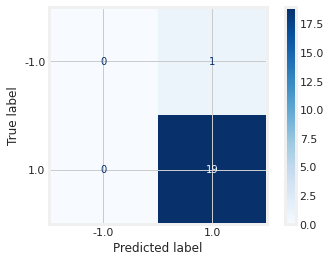

,score_in,score_out
0,92.5,95.0


In [34]:
# finding results  out of sample
score, results = best_xgb(X_train, X_test, y_train, y_test, score = accuracy_score, grid= best_grid)

# print score
score

In [35]:
#print results
results

,true_label,prediction,probability
0,1.0,1.0,0.804461
1,1.0,1.0,0.780197
2,1.0,1.0,0.782339
3,1.0,1.0,0.765158
4,1.0,1.0,0.804461
5,1.0,1.0,0.804461
6,1.0,1.0,0.763542
7,1.0,1.0,0.804461
8,1.0,1.0,0.804461
9,1.0,1.0,0.804461
